# Lab: Linear Regression + Model Evaluation
Drew Malter, Matt Winkler    
Slalom    
July 2018    

## Overview
The goal of this lab is to provide a hands-on introduction to the main tools/methods for creating and evaluating supervised learning regression models. This lab covers well established regression practices along with statistical reasoning as it works through a problem from start to finish.

The examples here utilize data from a large car insurance provider seeking to predict the amount a customer is willing to spend on an insurance policy with given information about each customer.  The benefits of these predictions are extremely valuable to both the sales agents and the marketing team. 

Sales Agents: Provides them the crucial advatnage of knowing what a customer is probably willing to spend as they help their customers find a policy

Marketing: Allows them to focus their marketing campaigns on an audience that will spend more money, or attempt to move a low spending customer base into a higher spending customer base.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn import linear_model

%matplotlib inline

from ipywidgets import interact, widgets

from bokeh.io import push_notebook, show, output_notebook, curdoc
from bokeh.plotting import figure
from bokeh.models.annotations import Title
from bokeh.models.widgets import MultiSelect
from bokeh.models import Button
from bokeh.layouts import widgetbox, column, row

C:\Users\drew.malter\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#load in the data set 
#Will leverage the s3 bucket for the lab
#Import 3 data sets; orders, prices, and customers
os.chdir('C:/Users/drew.malter/Documents/AIML Workshop/SalesDatasets')
df = pd.read_csv('CarInsurance_Claims.csv')

Before getting started with the model build, we will walk through the inspection phase which will allow us to get a better idea about 'cause and effect' relationship that independent variables have on the dependent variable, cost.  This step is also necessary in the likely case that we will need to modify the data in order to set ourselves up to build a more accurate model.  

In [ ]:
#Variable Descriptions

# customer_ID - A unique identifier for the customer
# shopping_pt - Unique identifier for the shopping point of a given customer
# record_type - 0=shopping point, 1=purchase point
# day - Day of the week (0-6, 0=Monday)
# time - Time of day (HH:MM)
# state - State where shopping point occurred
# location - Location ID where shopping point occurred
# group_size - How many people will be covered under the policy (1, 2, 3 or 4)
# homeowner - Whether the customer owns a home or not (0=no, 1=yes)
# car_age - Age of the customer’s car
# car_value - How valuable was the customer’s car when new
# risk_factor - An ordinal assessment of how risky the customer is (1, 2, 3, 4)
# age_oldest - Age of the oldest person in customer's group
# age_youngest - Age of the youngest person in customer’s group
# married_couple - Does the customer group contain a married couple (0=no, 1=yes)
# C_previous - What the customer formerly had or currently has for product option C (0=nothing, 1, 2, 3,4)
# duration_previous -  how long (in years) the customer was covered by their previous issuer
# A,B,C,D,E,F,G - the coverage options


# cost - cost of the quoted coverage options

In [3]:
#Look at the first 5 rows of the data set
df.head()

,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
0,10000000,1,0,0,8:35,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,2,633
1,10000000,2,0,0,8:38,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
2,10000000,3,0,0,8:38,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
3,10000000,4,0,0,8:39,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
4,10000000,5,0,0,11:55,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630


In [4]:
#See number of rows and columns in table
df.shape

(665249, 25)

We are going to drop the A-G columns for this exercise, since they're categorical dependent variables which don't have a relationship with the rest of the predictor variables or the cost. We'll also remove customer_ID to avoid overfitting the predictions to individual customers.

In [5]:
df.drop(columns=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'customer_ID'], 
        axis = 1, 
       inplace=True)

In [6]:
#Look for missing data
NaN_Count = pd.DataFrame(df.isnull().sum(axis = 0))
Total_Count = pd.DataFrame(df.count(axis = 0))
Percent_NaN = pd.DataFrame((df.isnull().sum(axis = 0))/((df.count(axis = 0)) + (df.isnull().sum(axis = 0))))

df_nulls = pd.concat([NaN_Count, Total_Count, Percent_NaN], axis=1)
df_nulls.columns = ['Missing Observations', 'Observations', 'Percent_NaN'] 
df_nulls

,Missing Observations,Observations,Percent_NaN
shopping_pt,0,665249,0.000000
record_type,0,665249,0.000000
day,0,665249,0.000000
time,0,665249,0.000000
state,0,665249,0.000000
location,0,665249,0.000000
group_size,0,665249,0.000000
homeowner,0,665249,0.000000
car_age,0,665249,0.000000
car_value,1531,663718,0.002301


There are a relatively high number of nulls in the risk_factor column at over 35%. C_previous and duration_previous are also missing some values. There are many methods for dealing with missing data (inputting mean, median, separate classification / regression models). In this case, we are fortunate to have a lot of data in this set so we can afford to just drop the rows with missing data.

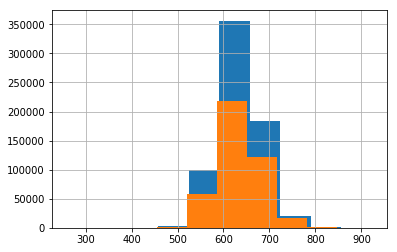

In [7]:
df_new = df.dropna()

# check shape of distributions with and without NAs
df['cost'].hist()
df_new['cost'].hist()

In [8]:
# List data types
df_new.dtypes

shopping_pt            int64
record_type            int64
day                    int64
time                  object
state                 object
location               int64
group_size             int64
homeowner              int64
car_age                int64
car_value             object
risk_factor          float64
age_oldest             int64
age_youngest           int64
married_couple         int64
C_previous           float64
duration_previous    float64
cost                   int64
dtype: object

In [139]:
#Look at the summary statistics of each numeric field
df.describe()

,shopping_pt,record_type,location,homeowner,car_age,age_oldest,age_youngest,married_couple,C_previous,duration_previous,cost,day_1,day_2,day_3,day_4,day_5,day_6,state_AR,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_IA,state_ID,state_IN,state_KS,state_KY,state_MD,state_ME,state_MO,state_MS,state_MT,state_ND,state_NE,state_NH,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SD,state_TN,state_UT,state_WA,state_WI,state_WV,state_WY,group_size_2,group_size_3,group_size_4,risk_factor_2.0,risk_factor_3.0,risk_factor_4.0,car_value_b,car_value_c,car_value_d,car_value_e,car_value_f,car_value_g,car_value_h,car_value_i
count,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.00000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000
mean,4.267471,0.149133,12275.645248,0.594186,7.642077,48.032181,45.544067,0.226383,2.596406,6.679780,632.695010,0.206853,0.200943,0.182797,0.179000,0.013036,0.001713,0.007555,0.026293,0.017102,0.002582,0.009515,0.248563,0.009649,0.004065,0.013769,0.056714,0.00585,0.012524,0.066013,0.005450,0.013214,0.008171,0.003620,0.001092,0.003842,0.007850,0.007184,0.014967,0.214001,0.037504,0.011326,0.018668,0.062748,0.007414,0.000493,0.017231,0.013422,0.031384,0.010217,0.004983,0.001349,0.217795,0.014117,0.001052,0.229445,0.274435,0.260229,0.001706,0.028533,0.165968,0.323457,0.271759,0.152070,0.048164,0.006868
std,2.397240,0.356220,1552.833289,0.491050,5.326215,17.878804,18.144699,0.418490,1.007123,4.825717,46.219299,0.405049,0.400706,0.386500,0.383353,0.113430,0.041350,0.086593,0.160006,0.129650,0.050751,0.097080,0.432181,0.097755,0.063629,0.116533,0.231295,0.07626,0.111207,0.248305,0.073621,0.114189,0.090024,0.060054,0.033033,0.061868,0.088252,0.084454,0.121422,0.410128,0.189994,0.105819,0.135351,0.242510,0.085786,0.022209,0.130131,0.115074,0.174352,0.100561,0.070412,0.036700,0.412748,0.117973,0.032412,0.420476,0.446230,0.438760,0.041264,0.166490,0.372053,0.467796,0.444867,0.359089,0.214113,0.082588
min,1.000000,0.000000,10001.000000,0.000000,0.000000,18.000000,16.000000,0.000000,1.000000,0.000000,260.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,10965.000000,0.000000,3.000000,31.000000,28.000000,0.000000,2.000000,3.000000,601.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [140]:
df_new.describe()

,shopping_pt,record_type,day,location,group_size,homeowner,car_age,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous,cost
count,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000
mean,4.267471,0.149133,1.948587,12275.645248,1.249184,0.594186,7.642077,2.559003,48.032181,45.544067,0.226383,2.596406,6.679780,632.695010
std,2.397240,0.356220,1.452714,1552.833289,0.470781,0.491050,5.326215,1.112997,17.878804,18.144699,0.418490,1.007123,4.825717,46.219299
min,1.000000,0.000000,0.000000,10001.000000,1.000000,0.000000,0.000000,1.000000,18.000000,16.000000,0.000000,1.000000,0.000000,260.000000
25%,2.000000,0.000000,1.000000,10965.000000,1.000000,0.000000,3.000000,2.000000,31.000000,28.000000,0.000000,2.000000,3.000000,601.000000
50%,4.000000,0.000000,2.000000,12037.000000,1.000000,1.000000,7.000000,3.000000,49.000000,45.000000,0.000000,3.000000,6.000000,631.000000
75%,6.000000,0.000000,3.000000,13427.000000,1.000000,1.000000,11.000000,4.000000,64.000000,62.000000,0.000000,3.000000,10.000000,662.000000
max,13.000000,1.000000,6.000000,16580.000000,4.000000,1.000000,23.000000,4.000000,75.000000,75.000000,1.000000,4.000000,15.000000,911.000000


There are a couple of things to note from the output above. One, we didn't change the variable distributions too much by removing records with missing values. If we had, we'd risk affecting the coefficient estimates produced by the regression.

By comparing the mean and median values, we can also see that several variables have skewed distributions, since the mean and median are far apart. There are a couple remaining steps for our data prep:

1) The above only looks at the numeric features in the data. We should also look at the categoricals to determine whether they have any potential value.

2) Regression is sensitive to outliers in the data, so we want to evaluate and address variable skew before proceeding further.

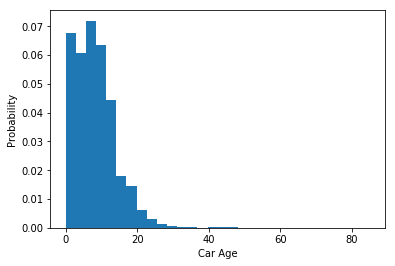

In [10]:
#Plot a histogram of car age, note that there are large outliers inflating the mean higher than the median
plt.hist(df['car_age'], density=True, bins=30)
plt.ylabel('Probability')
plt.xlabel('Car Age');

In [142]:
df = df_new
del df_new

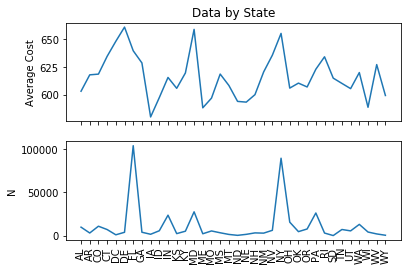

In [145]:
#Look at how state could be a predictor of cost

state_cost = df.groupby('state')['cost'].mean()
state_count = df.groupby('state').size()

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
_ = ax1.plot(state_cost)
_ = ax1.set_ylabel('Average Cost')
_ = ax1.set_title('Data by State')
_ = ax2.plot(state_count)
_ = ax2.set_ylabel('N')

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

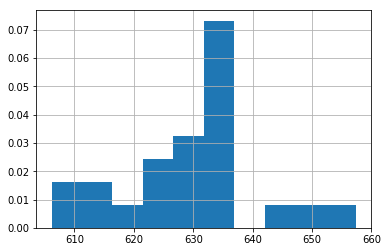

In [146]:
# get the times as a list and round to the hour:
times = df['time'].values.tolist()
df['time'] = [tm.split(':')[0] for tm in times]

times = df.groupby('time')['cost'].mean()

_ = times.hist(density=True)

There isn't much variation of the cost across different values of the time variable. So, let's drop this feature.

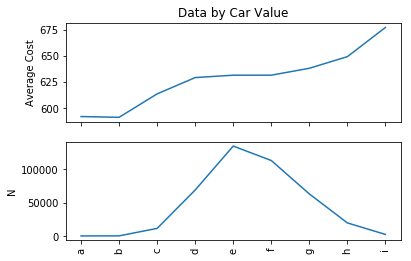

In [148]:
car_cost = df.groupby('car_value')['cost'].mean()
car_counts = df.groupby('car_value').size()

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
_ = ax1.plot(car_cost)
_ = ax1.set_ylabel('Average Cost')
_ = ax1.set_title('Data by Car Value')
_ = ax2.plot(car_counts)
_ = ax2.set_ylabel('N')

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

There appears to be a relationship between the car_value feature and the cost. However, there are relatively few observations at the high and low ends of car_value. We can try bucketing values a-c and g-i together.

In [149]:
df.loc[df['car_value'].isin(['a', 'b', 'c']), 'car_value'] = 'a-c'
df.loc[df['car_value'].isin(['g', 'h', 'i']), 'car_value'] = 'g-i'

In [150]:
# remove the time variable as discussed earlier:
df.drop(columns=['time'], axis=1, inplace=True)

In [151]:
#move higher up
# clean up duration_previous, C_previous, and risk_factor columns since they should be ints
df['duration_previous'] = df['duration_previous'].astype(int)
df['C_previous'] = df['C_previous'].astype(int)
df['risk_factor'] = df['risk_factor'].astype(int)

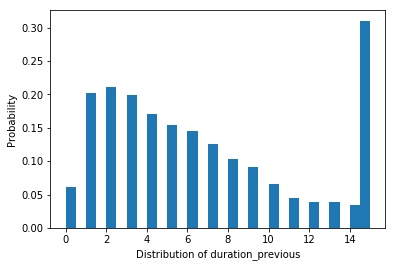

In [152]:
# Example plotting a single variable to evaluate its skew:
feature = 'duration_previous'
plt.hist(df[feature], density=True, bins=30)
plt.ylabel('Probability')
plt.xlabel('Distribution of {}'.format(feature));

What if we had a dataset with 1,000 (or 10,000) variables and wanted to evaluate the skew for each? We'd need a lot of code! Or, we can use a more interactive approach to look at each variable in turn with the Bokeh library.

In [159]:
# plot setup:
p = figure(title="Test", 
           background_fill_color="#E8DDCB", 
           width=500, 
           height=300)

# get values and make histogram:
arr = df['car_age'].values
hist, edges = np.histogram(arr, 
                           density=True, 
                           bins=50)

# assign histogram to the figure:
r = p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")

show(p)

# update() function to make the plot interactive:
def update(feature, num_bins):
    # update array and histogram values:
    arr = df[feature].values
    hist, edges = np.histogram(arr, 
                           density=True, 
                           bins=num_bins)
    
    # update plot parameters:
    p.title.text = 'Probability distribution of {}'.format(feature)
    p.xaxis.axis_label = '{}'.format(feature)
    p.yaxis.axis_label = 'Pr({})'.format(feature)
    
    # reset the renderer data:
    r.data_source.data['top'] = hist
    r.data_source.data['left'] = edges[:-1]
    r.data_source.data['right'] = edges[1:]
    
    push_notebook()

output_notebook()

Loading BokehJS ...

In [160]:
features = [f for f in df.columns.values if f not in ['car_value', 'state']]
nbins = (5, 50)
interact(update, feature = features, num_bins = nbins)
show(p, notebook_handle = True)

interactive(children=(Dropdown(description='feature', options=('shopping_pt', 'record_type', 'day', 'location', 'group_size', 'homeowner', 'car_age', 'risk_factor', 'age_oldest', 'age_youngest', 'married_couple', 'C_previous', 'duration_previous', 'cost'), value='shopping_pt'), IntSlider(value=27, description='num_bins', max=50, min=5), Output()), _dom_classes=('widget-interact',))

In [155]:
def min_max(col):
    """Min-max scales input to 0-1 range."""
    mn = min(col)
    mx = max(col)
    scaled = ((col - mn) / (mx - mn))
    return scaled

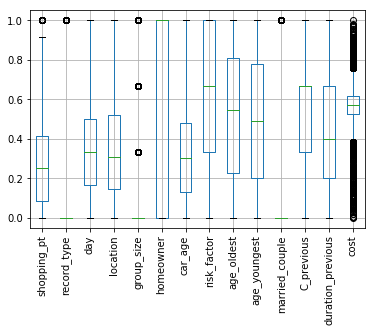

In [157]:
#tie in histogram of cost here
scaled = df[features].apply(min_max)
my_plt = scaled.boxplot(rot=90)

Based on the above, car_age could be capped based on its high skew. Check first whether there is a clear relationship between the two.

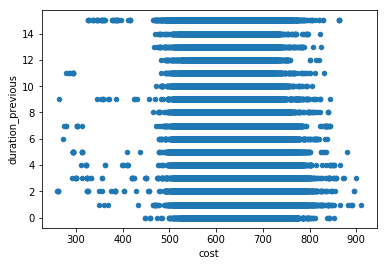

In [158]:
_ = df.plot.scatter('cost', 'duration_previous')

The Bokeh library provides an interactive interface for examining each feature in the data.

In [161]:
# plot setup:
p = figure(title="Test", 
           background_fill_color="#E8DDCB", 
           width=500, 
           height=300)

# get values and make histogram:
arr = df['car_age'].values
hist, edges = np.histogram(arr, 
                           density=True, 
                           bins=50)

# Setup x axis based on the data:
#arr_min = min(arr)
#arr_max = max(arr)
#n_unique = len(np.unique(arr))
#x = np.linspace(arr_min, arr_max, n_unique)

# assign histogram to the figure:
r = p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")

# labelling:
#p.legend.location = "center_right"
#p.legend.background_fill_color = "darkgrey"
#p.xaxis.axis_label = 'x'
#p.yaxis.axis_label = 'Pr(x)'

# show static plot:
#show(p)

In [162]:
# update() function to make the plot interactive:
def update(feature, num_bins):
    # update array and histogram values:
    arr = df[feature].values
    hist, edges = np.histogram(arr, 
                           density=True, 
                           bins=num_bins)
    
    # update plot parameters:
    p.title.text = 'Probability distribution of {}'.format(feature)
    p.xaxis.axis_label = '{}'.format(feature)
    p.yaxis.axis_label = 'Pr({})'.format(feature)
    
    # reset the renderer data:
    r.data_source.data['top'] = hist
    r.data_source.data['left'] = edges[:-1]
    r.data_source.data['right'] = edges[1:]
    
    push_notebook()

In [163]:
features = df.columns.values
nbins = (10, 50)
interact(update, feature = features, num_bins = nbins)
show(p, notebook_handle = True)

interactive(children=(Dropdown(description='feature', options=('shopping_pt', 'record_type', 'day', 'state', 'location', 'group_size', 'homeowner', 'car_age', 'car_value', 'risk_factor', 'age_oldest', 'age_youngest', 'married_couple', 'C_previous', 'duration_previous', 'cost'), value='shopping_pt'), IntSlider(value=30, description='num_bins', max=50, min=10), Output()), _dom_classes=('widget-interact',))

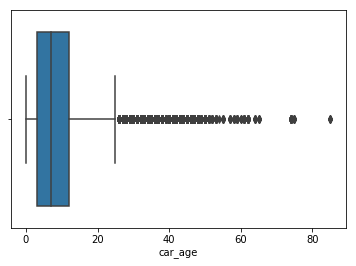

In [14]:
#might be able to get rid of
# example boxplot for the group size feature. TODO: make dynamic with bokeh
sns.boxplot(df['car_age'])

In [15]:
#one possible outlier removal method,
# define outlier adjustment function:
def adjust_outliers(array_in):
    """ Finds and replaces outliers in input array with 1.5 * IQR"""
    array_out = np.array(array_in)
    
    q1 = array_in.quantile(q=0.25)
    q3 = array_in.quantile(q=0.75)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    
    below_ind = array_out < lower
    above_ind = array_out > upper
    
    array_out[below_ind] = lower
    array_out[above_ind] = upper
    
    changed = np.sum(array_in != array_out)
    print('Found and adjusted {} values in {} column'.format(str(changed), array_in.name))
    return array_out

In [16]:
# Adjust the outliers in the car_age column:
df_new['car_age'] = adjust_outliers(df_new['car_age'])

Found and adjusted 4896 values in car_age column


C:\Users\drew.malter\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


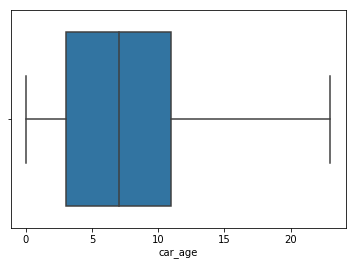

In [17]:
# confirm the above method worked with a new box plot:
sns.boxplot(df_new['car_age'])

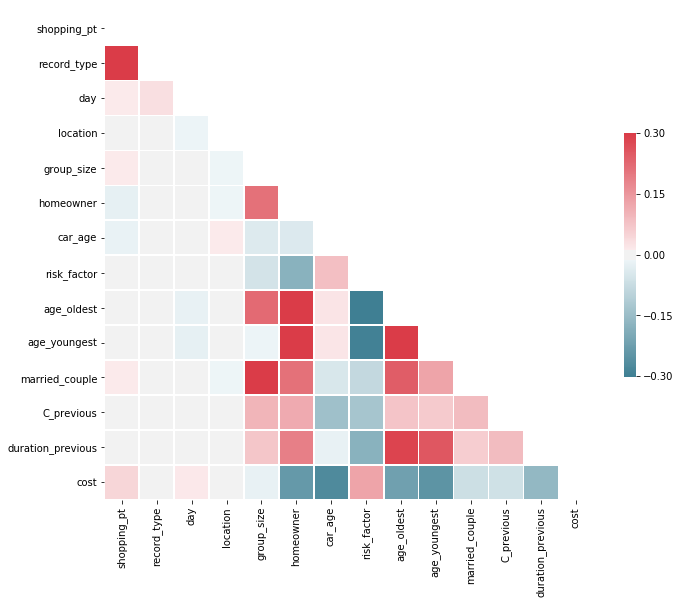

In [18]:
# Look at correlation matrix of numeric variables:

# Compute the correlation matrix
corr = df_new.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Overall there don't appear to be strong correlations in the dataset across the intput variables or with the target. age_oldest and age_youngest are an exception, with a correlation of over .9. We should encode some of the features as binary variables since their values don't necessarily represent incremental increases

In [19]:
df_new.nunique()

shopping_pt            13
record_type             2
day                     7
time                 1105
state                  36
location             5888
group_size              4
homeowner               2
car_age                24
car_value               9
risk_factor             4
age_oldest             58
age_youngest           60
married_couple          2
C_previous              4
duration_previous      16
cost                  472
dtype: int64

In [20]:
# one-hot encoding of categorical columns:# one-hot 
df = pd.get_dummies(df_new,
                    drop_first=True,
                    columns = ['day', 'state', 'group_size', 
                               'risk_factor', 'car_value'])

now for the model build

In [133]:
# Set cost to the dependent variable and choose features as the predictors
y = df.cost
X = df.drop(columns=['cost', 'location', 'time', 'shopping_pt', 'age_youngest'])

In [134]:
lm = linear_model.LinearRegression()

#Split data set into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

#Fit the model :
lm.fit(X_train, y_train)

#Set predictions
lm_train_pred = lm.predict(X_train)
lm_test_pred = lm.predict(X_test)


Evaluation

In [135]:
#Return the summary of the model
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     4549.
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        15:41:30   Log-Likelihood:            -2.0848e+06
No. Observations:              417447   AIC:                         4.170e+06
Df Residuals:                  417384   BIC:                         4.170e+06
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               636.5551      1.53

As part of the model evaluation process, let's put ourselves in the shoes of someone who would be using this model.  Let's imagine we are sales agents and a customer walks in with a given set of attributes.  How much are we predicting that this individual customer is willing to spend on a policy?

In [164]:
#add in r squared for training set vs test set

In [136]:
pd.set_option('display.max_columns', None)
df_individual = X_test.iloc[[222]]
df_individual

,record_type,homeowner,car_age,age_oldest,married_couple,C_previous,duration_previous,day_1,day_2,day_3,day_4,day_5,day_6,state_AR,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_IA,state_ID,state_IN,state_KS,state_KY,state_MD,state_ME,state_MO,state_MS,state_MT,state_ND,state_NE,state_NH,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SD,state_TN,state_UT,state_WA,state_WI,state_WV,state_WY,group_size_2,group_size_3,group_size_4,risk_factor_2.0,risk_factor_3.0,risk_factor_4.0,car_value_b,car_value_c,car_value_d,car_value_e,car_value_f,car_value_g,car_value_h,car_value_i
438776,0,0,11,20,0,3.0,4.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [137]:
#Predict the amount that this individual will spend on a policy
lm_test_pred[222]

655.6766547564407

In [138]:
y_test.iloc[[222]]

438776    646
Name: cost, dtype: int64

Above we just looked at one example.  The mean squared error metric is a way to measure the accuracy of our model by comparing all predictions with their corresponding actual values. 

Residuals are defined as the difference between the predicted values from your model and the actual values in the data.  In a good linear regression model, the residuals will be normally distributed. Check to see if this is the case.

In [131]:
from sklearn.metrics import mean_squared_error

print("Mean Squared Error \n Training Data: {}\n Test Data: {}".format(mean_squared_error(y_train, lm_train_pred), mean_squared_error(y_test, lm_test_pred)))

ValueError: y_true and y_pred have different number of output (2!=1)

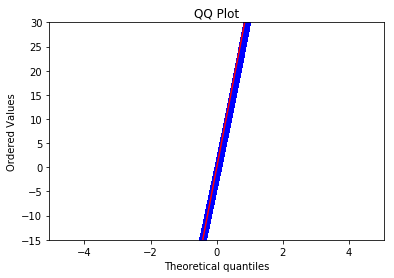

In [64]:
import numpy as np 
import pylab 
import scipy.stats as stats

residuals = y_train- lm_train_pred
stats.probplot(residuals, dist="norm", plot=pylab )
pylab.ylim([-15,30])
pylab.title("QQ Plot")
pylab.show()